In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 29 22:57:12 2017

@author: longang
@comments by Zhi Zeng
"""

import keras

from keras.models import Model
from keras.layers import Activation, Input, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Cropping2D, MyUpSampling2D
"""
Note: The module MyUpSampling2D is written by the author.
"""
from keras.layers.pooling import MaxPooling2D
from keras import regularizers

class FgSegNetModule(object):
    
    def __init__(self, lr, reg, img_shape, scene, vgg_weights_path):
        self.lr = lr # Is this the learning rate ??
        self.reg = reg # The weight for the l2 regularizer for the Tconv
        self.img_shape = img_shape # the shape of the image ??
        self.scene = scene # ???
        self.vgg_weights_path = vgg_weights_path # the path for the vgg_weights

    def VGG16(self, x): 
        """
        Note: This defines the structure of the vgg16. Note that each layer has a unique name in the definition.
        """
        
        # Block 1
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format='channels_last')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
        """
        Note:
        data_format: A string, one of channels_last (default) or channels_first. 
        The ordering of the dimensions in the inputs. 
        channels_last corresponds to inputs with shape (batch, height, width, channels) 
        while channels_first corresponds to inputs with shape (batch, channels, height, width). 
        It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. 
        If you never set it, then it will be "channels_last".
        """
        # Block 2
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
        # Block 3
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    
        # Block 4
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
        x = Dropout(0.5, name='dr1')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
        x = Dropout(0.5, name='dr2')(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
        x = Dropout(0.5, name='dr3')(x)
        
        return x
        
    def transposedConv(self, x):
        """
        Note:
        Regularizers allow to apply penalties on layer parameters or layer activity during optimization. 
        These penalties are incorporated in the loss function that the network optimizes.
        The penalties are applied on a per-layer basis. 
        The exact API will depend on the layer, but the layers Dense, Conv1D, Conv2D and Conv3D have a unified API.
        These layers expose 3 keyword arguments:
        kernel_regularizer: instance of keras.regularizers.Regularizer
        bias_regularizer: instance of keras.regularizers.Regularizer
        activity_regularizer: instance of keras.regularizers.Regularizer
        Example
        from keras import regularizers
        model.add(Dense(64, input_dim=64,
                        kernel_regularizer=regularizers.l2(0.01),
                        activity_regularizer=regularizers.l1(0.01)))
        Available penalties
        keras.regularizers.l1(0.)
        keras.regularizers.l2(0.)
        keras.regularizers.l1_l2(0.)
        For each of the Tconv block, there is a regularizer. 
        I am not sure why the regularizer should be used here?
        """
        
        # block 5
        x = Conv2DTranspose(64, (1, 1), activation='relu', padding='same', name='block5_tconv1', 
                            kernel_regularizer=regularizers.l2(self.reg))(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', name='block5_tconv2')(x)
        x = Conv2DTranspose(512, (1, 1), activation='relu', padding='same', name='block5_tconv3')(x)
        
        # block 6
        x = Conv2DTranspose(64, (1, 1), activation='relu', padding='same', name='block6_tconv1', 
                            kernel_regularizer=regularizers.l2(self.reg))(x)
        x = Conv2DTranspose(64, (5, 5), strides=(2, 2), activation='relu', padding='same', name='block6_tconv2')(x)
        x = Conv2DTranspose(256, (1, 1), activation='relu', padding='same', name='block6_tconv3')(x)
        
        # block 7
        x = Conv2DTranspose(64, (1, 1), activation='relu', padding='same', name='block7_tconv1', 
                            kernel_regularizer=regularizers.l2(self.reg))(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', name='block7_tconv2')(x)
        x = Conv2DTranspose(128, (1, 1), activation='relu', padding='same', name='block7_tconv3')(x)
        
        # block 8
        x = Conv2DTranspose(64, (5, 5), strides=(2, 2), activation='relu', padding='same', name='block8_conv1', 
                            kernel_regularizer=regularizers.l2(self.reg))(x)
        
        # block 9
        x = Conv2DTranspose(1, (1, 1), padding='same', name='block9_conv1')(x)
        x = Activation('sigmoid')(x)
        
        return x

    def initModel (self):
        h, w, d = self.img_shape # height width dimension
        
        input_1 = Input(shape=(h, w, d), name='ip_scale1')
        vgg_layer_output = self.VGG16(input_1)
        shared_model = Model(inputs=input_1, outputs=vgg_layer_output, name='shared_model')
        shared_model.load_weights(self.vgg_weights_path, by_name=True)
        """
        Note:
        model.load_weights(filepath, by_name=False): 
        loads the weights of the model from a HDF5 file (created by save_weights). 
        By default, the architecture is expected to be unchanged. 
        To load weights into a different architecture (with some layers in common), 
        use by_name=True to load only those layers with the same name.
        """
        
        unfreeze_layers = ['block4_conv1','block4_conv2', 'block4_conv3']
        for layer in shared_model.layers:
            if(layer.name not in unfreeze_layers):
                layer.trainable = False
        """
        Note:
        Only the last block of the encoder will be trained.
        """
                
        # Scale 1
        x1_ups = {'streetCornerAtNight':(0,1), 'tramStation':(1,0), 'turbulence2':(1,0)} # ???
        x1 = shared_model.output
        """
        Cropping2D   
        keras.layers.Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
        Cropping layer for 2D input (e.g. picture).
        It crops along spatial dimensions, i.e. width and height.
        Arguments
        cropping: int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
        If int: the same symmetric cropping is applied to width and height.
        If tuple of 2 ints: interpreted as two different symmetric cropping values for height and width: 
            (symmetric_height_crop, symmetric_width_crop).
        If tuple of 2 tuples of 2 ints: interpreted as ((top_crop, bottom_crop), (left_crop, right_crop))
        data_format: A string, one of channels_last (default) or channels_first. 
        Examples
        # Crop the input 2D images or feature maps
        model = Sequential()
        model.add(Cropping2D(cropping=((2, 2), (4, 4)),
                             input_shape=(28, 28, 3)))
        # now model.output_shape == (None, 24, 20, 3)
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Cropping2D(cropping=((2, 2), (2, 2))))
        # now model.output_shape == (None, 20, 16. 64)
        """
        if(self.scene=='wetSnow'):
            x1 = Cropping2D(cropping=((1, 2),(0, 0)))(x1)
        elif(self.scene=='skating'):
            x1 = Cropping2D(cropping=((1, 1),(1, 2)))(x1)
        else:
            for key, val in x1_ups.items():
                if self.scene==key:
                    # upscale by adding number of pixels to each dim.
                    x1 = MyUpSampling2D(size=(1,1), num_pixels=val)(x1)
                    break
        """
        Note:
        For the first scale, only expending operations are used.
        """
            
        # Scale 2
        x2_ups = {'tunnelExit_0_35fps':(0,1),'tramCrossroad_1fps':(1,0),'bridgeEntry':(1,1),
                  'busyBoulvard':(1,0),'fluidHighway':(0,1),'streetCornerAtNight':(1,1), 
                  'tramStation':(2,0),'winterStreet':(1,0),'twoPositionPTZCam':(1,0),
                  'peopleInShade':(1,1),'turbulence2':(1,1),'turbulence3':(1,0),
                  'skating':(1,1), 'wetSnow':(0,0)}
        
        input_2 = Input(shape=(int(h/2), int(w/2), d), name='ip_scale2')
        x2 = shared_model(input_2)
        x2 = UpSampling2D((2,2))(x2)
        for key, val in x2_ups.items():
            if self.scene == key and self.scene in ['skating', 'wetSnow']:
                x2 = Cropping2D(cropping=((1, 1), val))(x2)
                break
            elif self.scene==key:
                x2 = MyUpSampling2D(size=(1, 1), num_pixels=val)(x2)
                break
        """
        Note:
        Multiple input fashion in Keras. Nothing but updating and expending.
        """
            
        # Scale 3
        x3_ups = {'tunnelExit_0_35fps':(2,3),'tramCrossroad_1fps':(3,0),'bridgeEntry':(3,1,),
                  'busyBoulvard':(3,0),'fluidHighway':(0,3),'streetCornerAtNight':(1,1),
                  'tramStation':(2,0),'winterStreet':(1,0),'twoPositionPTZCam':(1,2),
                  'peopleInShade':(1,3),'turbulence2':(3,1),'turbulence3':(1,0),
                  'office':(0,2), 'pedestrians':(0,2), 'bungalows':(0,2), 'busStation':(0,2)}
                
        input_3 = Input(shape=(int(h/4), int(w/4), d), name='ip_scale3')
        x3 = shared_model(input_3)
        x3 = UpSampling2D((4,4))(x3)
        for key, val in x3_ups.items():
            if self.scene==key:
                x3 = MyUpSampling2D(size=(1,1), num_pixels=val)(x3)
                break
        """
        Note:
        Nothing but upsampling and expending.
        """
            
        # concatenate feature maps
        top = keras.layers.concatenate([x1, x2, x3], name='feature_concat')
        if(self.scene=='wetSnow'):
            top = MyUpSampling2D(size=(1,1), num_pixels=(3,0))(top)
        elif(self.scene=='skating'):
            top = MyUpSampling2D(size=(1,1), num_pixels=(2,3))(top)
        """
        Note:
        Concatenate and expending
        """
        
        # Transposed Conv
        top = self.transposedConv(top)
        # i chose this crazy upscaling/cropping way
        if(self.scene=='tramCrossroad_1fps'):
            top = MyUpSampling2D(size=(1,1), num_pixels=(2,0))(top)
        elif(self.scene=='bridgeEntry'):
            top = MyUpSampling2D(size=(1,1), num_pixels=(2,2))(top)
        elif(self.scene=='fluidHighway'):
            top = MyUpSampling2D(size=(1,1), num_pixels=(2,0))(top)
        elif(self.scene=='streetCornerAtNight'): 
            top = MyUpSampling2D(size=(1,1), num_pixels=(1,0))(top)
            top = Cropping2D(cropping=((0, 0),(0, 1)))(top)
        elif(self.scene=='tramStation'):  
            top = Cropping2D(cropping=((1, 0),(0, 0)))(top)
        elif(self.scene=='twoPositionPTZCam'):
            top = MyUpSampling2D(size=(1,1), num_pixels=(0,2))(top)
        elif(self.scene=='turbulence2'):
            top = Cropping2D(cropping=((1, 0),(0, 0)))(top)
            top = MyUpSampling2D(size=(1,1), num_pixels=(0,1))(top)
        elif(self.scene=='turbulence3'):
            top = MyUpSampling2D(size=(1,1), num_pixels=(2,0))(top)

        vision_model = Model(inputs=[input_1, input_2, input_3], outputs=top, name='vision_model')
        opt = keras.optimizers.RMSprop(lr = self.lr, rho=0.9, epsilon=1e-08, decay=0.0)
        vision_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return vision_model

Using TensorFlow backend.


In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 29 22:22:22 2017

@author: longang
@Comments by Zhi Zeng
"""

get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')

"""
Note:
autoreload ensures that we can run a imported function, then, change the function in an editor and the changed function can be reloaded
"""

"""
Note:
get_ipython().magic('zzz') equals to %zzz
"""

import numpy as np
import tensorflow as tf
import random as rn
import os

# =============================================================================
#  For reprodocable results
# =============================================================================
#os.environ['PYTHONHASHSEED'] = '0'
# Environment variables are accessed through os.environ
# If PYTHONHASHSEED is set to an integer value, it is used as a fixed seed for generating the hash() of the types covered by the hash randomization.
#np.random.seed(42)
#rn.seed(12345)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# ConfigProto is used to configurate sesson()
# For both configuration options, if they are unset or set to 0, will default to the number of logical CPU cores. 
# Testing has shown that the default is effective for systems ranging from one CPU with 4 cores to multiple CPUs with 70+ combined logical cores. 
# A common alternative optimization is to set the number of threads in both pools equal to the number of physical cores rather than logical cores.
from keras import backend as K
#tf.set_random_seed(1234)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)

import keras, glob
from keras.preprocessing import image as kImage
from skimage.transform import pyramid_gaussian
from sklearn.utils import compute_class_weight
# from FgSegNetModule import FgSegNetModule
from keras.utils.data_utils import get_file

In [6]:
# =============================================================================
# Few frames, load into memory directly
# =============================================================================
# def generateData(train_dir, dataset_dir, scene):
    # It is weired that the parameter 'scene'is not used in the function
def generateData(train_dir, dataset_dir):
    void_label = -1. # The masked regions will be labeled as -1
    X_list = []
    Y_list = []
    
    # Given ground-truths, load training frames
    # ground-truths end with '*.png'
    # training frames end with '*.jpg'
    
    # scan over FgSegNet_dataset for groundtruths
    for root, _, _ in os.walk(train_dir):
        # Walk though the tree (root, dirs, files)
        gtlist = glob.glob(os.path.join(root,'*.png'))
        # list all *.png files
        if gtlist:
            Y_list = gtlist
        # I think the following two lines should be add
        else:
            Y_list += gtlist
    
    # scan over CDnet2014_dataset for .jpg files
    for root, _, _ in os.walk(dataset_dir):
        inlist = glob.glob(os.path.join(root,'*.jpg'))
        if inlist:
            X_list = inlist
        # I think the following two lines should be add
        else:
            X_list += inlist
    
    # filter matched files        
    # brutal force match
    # Only a subset of X_list is left and reordered
    X_list_temp = []
    for i in range(len(Y_list)):
        Y_name = os.path.basename(Y_list[i])
        Y_name = Y_name.split('.')[0]
        Y_name = Y_name.split('gt')[1]
        for j in range(len(X_list)):
            X_name = os.path.basename(X_list[j])
            X_name = X_name.split('.')[0]
            X_name = X_name.split('in')[1]
            if (Y_name == X_name):
                X_list_temp.append(X_list[j])
                break
    X_list = X_list_temp
    # The following line is negligable
    # del X_list_temp, inlist, gtlist
    
    # process training images
    X = []
    Y = []
    # Load all images and modify the lables
    for i in range(0, len(X_list)):
        x = kImage.load_img(X_list[i])
        x = kImage.img_to_array(x)
        X.append(x)
        # what is the type of X ?
        # Is the range of an element in X [0, 255] or [0,1]?
        
        x = kImage.load_img(Y_list[i], grayscale = True)
        x = kImage.img_to_array(x)
        shape = x.shape
        x /= 255.0
        x = x.reshape(-1)
        idx = np.where(np.logical_and(x>0.25, x<0.8))[0] # find non-ROI
        if (len(idx)>0):
            x[idx] = void_label # void_label = -1
            # After this operation, elements in Y can be only one of [0.0, 1.0, -1.0]
        x = x.reshape(shape)
        x = np.floor(x)
        Y.append(x)
    # The following line is negligable
    # del Y_list, X_list, x, idx
    X = np.asarray(X) # convert X to np.array
    Y = np.asarray(Y)
    
    # Shuffle the training data
    idx = list(range(X.shape[0])) # np.arange(X.shape[0])
    np.random.shuffle(idx)
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    # The following line is negligable
    # del idx
    
    # Image Pyramid
    scale1 = X
    # del X
    scale2 = []
    scale3 = []
    for i in range(0, scale1.shape[0]):
        pyramid = tuple(pyramid_gaussian(scale1[i]/255., max_layer=2, downscale=2))
        scale2.append(pyramid[1]) # 2nd scale
        scale3.append(pyramid[2]) # 3rd scale
        # del pyramid
    scale2 = np.asarray(scale2)
    scale3 = np.asarray(scale3)
    # I think the following line should added:
    scale1 = X/255.
    print (scale1.shape, scale2.shape, scale3.shape)

    # compute class weights
    cls_weight_list = []
    for i in range(Y.shape[0]):
        # For each groundtruth image, the auther compute the class weights. These class weights are stored in a list
        # I do not know why the author need this.
        y = Y[i].reshape(-1) # flattern Y
        idx = np.where(y!=void_label)[0] # for unmasked pixels
        if(len(idx)>0):
            y = y[idx] # exclude masked pixels
        lb = np.unique(y) #  0., 1.0
        cls_weight = compute_class_weight('balanced', lb , y)
        # cls_weight = n_samples/(n_classes*np.bincount(y)) = 320*240/(2*[64455, 12345])
        # np.bincount count the num of occurence of each non-neg ints
        # Put an emphasize on moving objects!!!
        class_0 = cls_weight[0]
        class_1 = cls_weight[1] if len(lb)>1 else 1.0
        
        cls_weight_dict = {0:class_0, 1: class_1}
        cls_weight_list.append(cls_weight_dict)
    # del y, idx
    cls_weight_list = np.asarray(cls_weight_list)
    # Three kinds of inputs, one outputs, and one weight list
    return [scale1, scale2, scale3, Y, cls_weight_list]

## Debug for generateData(train_dir, dataset_dir, scene)

In [7]:
train_dir = "E:\\Python Workspace\\FgSegNet\\FgSegNet_dataset2014\\baseline\\highway50\\"
dataset_dir = "E:\\Python Workspace\\FgSegNet\\CDnet2014_dataset\\baseline\\highway\\input\\"
[scale1, scale2, scale3, Y, cls_weight_list] = generateData(train_dir, dataset_dir)

(50, 240, 320, 3) (50, 120, 160, 3) (50, 60, 80, 3)


In [8]:
print(Y.shape)

(50, 240, 320, 1)


In [9]:
print(cls_weight_list.shape)

(50,)


In [11]:
print(cls_weight_list[0:5])

[{0: 0.55136976114697045, 1: 5.3666763173132601}
 {0: 0.54827836011768361, 1: 5.6783034757311288}
 {0: 0.55058667257029004, 1: 5.4420131291028451}
 {0: 0.56020535862370524, 1: 4.6524542950162786}
 {0: 0.55942626077668423, 1: 4.7068943381692128}]


In [12]:
import matplotlib.pyplot as plt

Class weights are:  {0: 0.5538188704199104, 1: 5.1452108349623007}


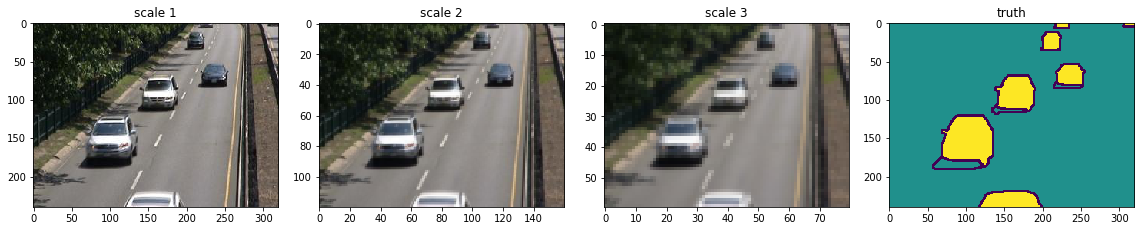

In [30]:
temp_sample_index = 20;

fig = plt.figure(figsize=(16,5))

fig.add_subplot(1,4,1)
plt.title('scale 1')
plt.imshow(scale1[temp_sample_index])
fig.add_subplot(1,4,2)
plt.title('scale 2')
plt.imshow(scale2[temp_sample_index])
fig.add_subplot(1,4,3)
plt.title('scale 3')
plt.imshow(scale3[temp_sample_index])
fig.add_subplot(1,4,4)
plt.title('truth')
plt.imshow(Y[temp_sample_index,:,:,0])
fig.tight_layout()
print('Class weights are: ',cls_weight_list[temp_sample_index])

In [20]:
def train(results, scene, mdl_path, log_dir, vgg_weights_path):
    
    # results: [scale1, scale2, scale3, Y, cls_weight_list]
    # scene: string for the name of the scene (link 'baseline')
    # mdl_path: store checkpoints of tensorflow
    # log_dir: used for tensorboard
    # vgg_weights_path: path for the vgg16 model
    
    img_shape = results[0][0].shape
    # results[0] = scale1 (numbers,width,height,channels)
    model = FgSegNetModule(lr, reg, img_shape, scene, vgg_weights_path)
    # it seems that lr (learning rate) and reg (regulizer weight) are defined outside
    model = model.initModel()
    
    # Create tensorboard info.
    tb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, 
                                     write_graph=False, write_grads=True, write_images=True, 
                                     embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    # Save the best model only
    chk = keras.callbacks.ModelCheckpoint(mdl_path, monitor='val_loss', verbose=0, 
                                          save_best_only=True, save_weights_only=True, mode='auto', period=1)
    '''
    Note:
    The above two statements are not stem from tensorflow. Rather, they are defined by keras.
    '''
    # Reduce the learning rate whena metrc has stoped improving
    # reduce_factor is defined outside
    # patience: consecutive number of steps with no action
    redu = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=reduce_factor, patience=num_patience, 
                                             verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    # verbose = 1: progress bar is shown
    # the above callbacks must be registed here
    # class_weight is used to weight the loss function !!!
    model.fit([results[0], results[1], results[2]], results[3], validation_split=0.2, epochs=epoch, batch_size=batch_size, 
                       callbacks=[redu, chk, tb], verbose=1, class_weight=results[4], shuffle = True)

    # del model, results, tb, chk, redu

In [31]:
results = [scale1, scale2, scale3, Y, cls_weight_list]
scene = 'highway'
mdl_path = "E:\\Python Workspace\\FgSegNet\\Temp_Debug_Folder\\Model\\best_model.h5"
log_dir = "E:\\Python Workspace\\FgSegNet\\Temp_Debug_Folder\\Logs\\"
vgg_weights_path = "E:\\Python Workspace\\FgSegNet\\Temp_Debug_Folder\\VGG16\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
num_frames = 50 # either 50 or 200 frames
reduce_factor = 0.1
num_patience = 6
lr = 1e-4
reg=5e-4 # weight of regularizer
# epoch = 60 if num_frames==50 else 50 # 50f->60epochs, 200f->50epochs
epoch = 6 # This is for debug only
batch_size = 1

In [32]:
train(results, scene, mdl_path, log_dir, vgg_weights_path)

Train on 40 samples, validate on 10 samples
Epoch 1/6
40/40 [==============================] - 153s 4s/step - loss: 2.4549 - acc: 0.8804 - val_loss: 1.9196 - val_acc: 0.8915
Epoch 2/6
40/40 [==============================] - 152s 4s/step - loss: 1.8403 - acc: 0.8958 - val_loss: 1.8972 - val_acc: 0.8915
Epoch 3/6
40/40 [==============================] - 153s 4s/step - loss: 1.8166 - acc: 0.8958 - val_loss: 1.8724 - val_acc: 0.8915
Epoch 4/6
40/40 [==============================] - 153s 4s/step - loss: 1.7920 - acc: 0.8958 - val_loss: 1.8486 - val_acc: 0.8915
Epoch 5/6
40/40 [==============================] - 153s 4s/step - loss: 1.7697 - acc: 0.8958 - val_loss: 1.8281 - val_acc: 0.8915
Epoch 6/6
40/40 [==============================] - 153s 4s/step - loss: 1.7509 - acc: 0.8958 - val_loss: 1.8111 - val_acc: 0.8915
